In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data

import numpy as np
import pandas as pd
import xarray as xr
import bottleneck as bn
import iris

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Define some filepaths that will be used a lot
home_dir = '/home/561/mg5624/RF_project/'
my_data_dir = '/g/data/w97/mg5624/'
shared_data_dir = '/g/data/w97/Shared_data/Observations/'

In [3]:
COORDS = {
    'SE_australia': {
        'lats': (-38, -27),
        'lons': (140, 154)
    },
}

## Take Necessary Data from Sanaa's Dataframe

In [4]:
# Load in Database from Sanaa's RF model
df = pd.read_csv(home_dir + '/Data/ML_Database_All_AWRA_MOf_and_3MPrecip.csv')

df = df.drop(df.columns[0], axis=1)

df.rename(columns = {'Drought / No Drought': 'Drought'}, inplace=True)
print(df)

     Year     Month Year_Month     Location  Latitude  Longitude  Drought  \
0    2014     March    2014-03        Cobar  -31.4980   145.8383        1   
1    2014  February    2014-02        Cobar  -31.4980   145.8383        1   
2    2014   January    2014-01        Cobar  -31.4980   145.8383        1   
3    2014     March    2014-03      Walgett  -30.0167   148.1167        1   
4    2014  February    2014-02      Walgett  -30.0167   148.1167        1   
..    ...       ...        ...          ...       ...        ...      ...   
930  2020  November    2020-11  Wagga Wagga  -35.1330   147.3670        0   
931  2020  December    2020-12  Wagga Wagga  -35.1330   147.3670        0   
932  2021   January    2021-01  Wagga Wagga  -35.1330   147.3670        0   
933  2021  February    2021-02  Wagga Wagga  -35.1330   147.3670        0   
934  2021     March    2021-03  Wagga Wagga  -35.1330   147.3670        0   

     Deep_Drainage  PET_Actual    E_Actual  Soil_M_root_zone      Qtot  \
0

In [5]:
# Create two databases from it - one with just the drought/no drought colomn and one with the climate drivers
columns_to_drop_for_drought = ['Deep_Drainage', 'PET_Actual', 'E_Actual', 'Soil_M_root_zone', 'Qtot', 'Rainfall', 'ENSO', 'IOD', 'SAM', 'P_acc_3M']
training_df = df.drop(columns_to_drop_for_drought, axis=1)

training_df.to_csv(home_dir + '/Data/drought_dataframe.csv')

# Process New Data

In [6]:
# Define functions needed for processing training data
def add_predictor_to_training_df(training_dataframe, predictor_dataset, predictor_name, replace=False):
    """
    Function which adds relevant data to the training dataframe.
    
    Args:
        training_dataframe (pd.DataFrame): dataframe containing all other training data
        predictor_dataset (xr.DataArray): xarray dataset of the predictor variable
        predictor_name (str): full name of the predictor variable
        replace (bool): if True and predictor_name already in df, it is replaced with new one (default=False)
    """
    # Return the original dataframe if predictor_name exists and we're not replacing it.
    if predictor_name in training_dataframe and not replace:
        return training_dataframe

    # Add empty column to training_df of predictor variable
    training_dataframe[predictor_name] = None
    
    # Find the lat, long, and time columns from the dataframe
    training_longs = training_dataframe['Longitude']
    training_lats = training_dataframe['Latitude']
    training_time = training_dataframe['Year_Month']

    # Loop over each entry in training_df and add the corresponding entry from the predictor dataset
    for i, time in enumerate(training_time):
        time_check = pd.to_datetime(time)
        if time_check <= predictor_dataset.coords['time'][-1].data:
            predictor_at_i = predictor_dataset.sel(time=time).sel(lon=training_longs[i], lat=training_lats[i], method='nearest').data
            training_dataframe[predictor_name].iat[i] = predictor_at_i
        else:
            break

    return training_dataframe
            

def rename_coord_titles_to_lat_long(dataset):
    """
    Changes the titles of the coordinates to lat long to keep it consistent
    
    Args:
        dataset (xr.DataSet): dataset with incorrect coordinate titles
    """
    # Define mapping from old to new name

    mapping = {
        'X': 'lon',
        'Y': 'lat'
    }
    
    renamed_dataset = dataset.rename(mapping)

    return renamed_dataset


def add_year_month_coord_to_dataarray(dataarray):
    """
    Adds year, month, and year_month coordinates to the input dataarray. 
    Requires dataarray to have time cooridnate in datetime format.

    Args:
        dataarray (xr.DataArray): dataarray to add coordinates to

    Returns:
        dataarray (xr.DataArray): 
            dataarray with additonal year, month, and year_month coordinates
    """
    # Add year_month coordinates to data
    dataarray['Year'] = dataarray['time'].dt.strftime('%Y')
    dataarray['Month'] = dataarray['time'].dt.strftime('%m')
    dataarray['Year_Month'] = dataarray['Year'] + '-' + dataarray['Month']

    return dataarray



def create_predictor_dataframe(start_year, end_year, area, data, data_name):
    """
    Creates a dataframe that runs from start year to end year, to be used to
    predict droughts in that time period. Predictors can then be added to 
    this dataframe using the add_predictor_to_predictors_dataframe function.
    
    Args:
        start_year (int): start year
        end_year (int): end year
        area (str): one of the areas defined in the COORDS dictionary
        data (xr.DataSet or xr.DataArray): 
            data of a predictor containing at least data covering the time period and area of interest
        data_name (str): name of the data
    
    Returns:
        constrained_df (pd.DataFrame): dataframe of data over specified area and time 
    """
    data = data.rename(data_name)
    
    lats = COORDS[area]['lats']
    lons = COORDS[area]['lons']

    lat_min, lat_max = lats[0], lats[1]
    lon_min, lon_max = lons[0], lons[1]

    start_year = str(start_year)
    end_year = str(end_year)
    
    constrained_data = data.sel(
        time=slice(start_year, end_year),
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max)
    )

    constrained_data = add_year_month_coord_to_dataarray(constrained_data)

    constrained_df = constrained_data.to_dataframe()
    constrained_df.reset_index(inplace=True)

    coord_rename = {
        'lon': 'Longitude',
        'lat': 'Latitude'
    }
    
    constrained_df.rename(columns=coord_rename, inplace=True)
   
    constrained_df['Latitude'] = constrained_df['Latitude'].astype(float).round(2)
    constrained_df['Longitude'] = constrained_df['Longitude'].astype(float).round(2)
    
    return constrained_df


def add_predictor_to_predictors_dataframe(predictors_df, new_predictor_data, new_predictor_name, replace=False):
    """
    Adds specified predictor data into the predictors dataframe.

    Args:
        predictor_df (pd.DataFrame): dataframe of the predictors
        new_predictor_data (xr.DataArray or pd.DataFrame): new predictor data to be added
        new_predictor_name (str): name of the new predictor
        replace (bool): if true, new predictor will replace any of the same name in dataframe

    Returns:
        merged_df (pd.DataFrame): predicotr_df with additional predictor in it            
    """
    # Return the original dataframe if predictor_name exists and we're not replacing it.
    if new_predictor_name in predictors_df and not replace:
        return predictors_df
    
    if isinstance(new_predictor_data, (xr.DataArray, xr.Dataset)):
        new_predictor_data = add_year_month_coord_to_dataarray(new_predictor_data)
        new_predictor_df = new_predictor_data.to_dataframe()
        new_predictor_df.reset_index(inplace=True)
    else:
        new_predictor_df = new_predictor_data
        dataframe['Month'] = dataframe['Month'].astype(int).astype(str)
        dataframe["Year_Month"] = dataframe['Year'].astype(str) + '-' + dataframe['Month'].str.zfill(2)
    
    merged_df = pd.merge(predictors_df, new_predictor_df, on='Year_Month', how='inner')

    return merged_df
    

## Precipitation

Using AGCD precipitation data which runs from 1900 to 2023 across the whole of Australia. Resolution is at 0.05 degrees.

In [7]:
precip_filepath = my_data_dir + '/RF_project/Precipitation/AGCD/'
precip = xr.open_dataarray(precip_filepath + 'AGCD_v1_precip_total_r005_monthly_1900_2021.nc')
print(precip)

<xarray.DataArray 'Precipitation' (time: 1464, lat: 691, lon: 861)>
[871008264 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 154.9 154.9 154.9 155.0
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2021-12-01
Attributes:
    standard_name:              lwe_thickness_of_precipitation_amount
    long_name:                  Daily precipitation
    units:                      mm
    grid_mapping:               crs
    cell_methods:               time: sum time: sum (interval : 1 day)
    analysis_version_number:    3.01
    start_offset:               -24
    frequency:                  monthly
    length_scale_for_analysis:  250.0
    coverage_content_type:      physicalMeasurement


In [8]:
print('starting')
precip_filepath = my_data_dir + '/RF_project/Precipitation/AGCD/'
print('filepath defined')
precip = xr.open_dataarray(precip_filepath + 'AGCD_v1_precip_total_r005_monthly_1900_2021.nc')
# precip = precip_ds.precip
print('precip loaded')
# previous_precip = precip.shift(time=1)
# print('prev precip calculated')

# training_df = add_predictor_to_training_df(training_df, previous_precip, 'Lagged_Precipitation')
training_df = add_predictor_to_training_df(training_df, precip, 'Precipitation')
print('added precip, lagged precip to df')
n_months = [3, 6, 12, 24, 36, 48]

for n in n_months:
    print(n)
    n_monthly_precip = xr.open_dataarray(precip_filepath + f'AGCD_v1_precip_total_r005_{n}monthly_1900_2021.nc')
    training_df = add_predictor_to_training_df(training_df, n_monthly_precip, f'Acc_{n}-Month_Precipitation')



starting
filepath defined
precip loaded
added precip, lagged precip to df
3
6
12
24
36
48


In [9]:
# predictors_df_1980 = add_predictor_to_predictors_dataframe(predictors_df_1980, precip_3months, 'Acc_3-Month_Precipitation')
# print(predictors_df_1980)

## Runoff

In [10]:
runoff = xr.open_dataarray('/g/data/w97/mg5624/RF_project/Runoff/AWRA/AWRAv7_Runoff_month_1911_2023.nc')
training_df = add_predictor_to_training_df(training_df, runoff, 'Runoff', replace=True)

## Climate Drivers: ENSO, IOD, SAM

In [11]:
def sort_tabled_dataframe_into_correct_form(dataframe, driver):
    """
    Takes in a dataframe with years down column 1 and months along row 1 and sorts it so that
    the columns are "Year", "Month", "Year_Month", index.
    
    Args:
        dataframe (pd.DataFrame): Dataframe of the dirvers index in tabular form
        driver (str): name of the driver
    """    
    original_cols = dataframe.columns
    if isinstance(original_cols[1], int) or original_cols[1] == '1':
        # Transform dataframe so that it has a month column instead of months on the rows
        melted_df = dataframe.melt(id_vars=['Year'], var_name='Month', value_name=f'{driver}_index')
        dataframe = melted_df
    else:    
        dataframe.rename(columns={'Index': f'{driver}_index'}, inplace=True)

    # Ensure Months are saved as 1 digit strings
    dataframe['Month'] = dataframe['Month'].astype(int).astype(str)
    
    # Create new "Year_Month" column
    dataframe["Year_Month"] = dataframe['Year'].astype(str) + '-' + dataframe['Month'].str.zfill(2)

    # Swap "Year_Month" column with index column
    new_cols = list(dataframe.columns)
    new_cols[3], new_cols[2] = new_cols[2], new_cols[3]
    switch_cols_df = dataframe[new_cols]

    # Remove Year and Month columns
    final_df = switch_cols_df[['Year_Month', f'{driver}_index']]
    return final_df


def add_drivers_df_to_training_df(training_df, driver):
    """
    Adds the data from the drivers index to the training dataframe.
    
    Args:
        training_df (pd.DataFrame): Dataframe containing the training data
        driver (str): name of the driver
    """
    # Define dictionary of driver to index name
    index_name = {'ENSO': 'BEST', 'IOD': 'DMI', 'SAM': 'AAO'}
    
    # Sort the dataframe into correct format
    df = pd.read_csv(my_data_dir + f'RF_project/{driver}/{driver}_{index_name[driver]}_index.csv')

    sorted_df = sort_tabled_dataframe_into_correct_form(df, driver)
    
    # Merge driver dataframe into training dataframe
    merged_df = pd.merge(training_df, sorted_df, on='Year_Month', how='inner')
    
    return merged_df

In [12]:
drivers = ['ENSO', 'IOD', 'SAM']
index_name = {'ENSO': 'BEST', 'IOD': 'DMI', 'SAM': 'AAO'}

for driver in drivers:    
    # Add the drivers to the training dataframe if they're not in there yet
    if not f'{driver}_index' in training_df.columns:
        training_df = add_drivers_df_to_training_df(training_df, driver)

    # Save the full drivers dataframes to my data dir
    df = pd.read_csv(my_data_dir + f'RF_project/{driver}/{driver}_{index_name[driver]}_index.csv')
    sorted_df = sort_tabled_dataframe_into_correct_form(df, driver)
    sorted_df.to_csv(my_data_dir + f'RF_project/{driver}/{driver}_{index_name[driver]}_index_sorted.csv')

## Evapotranspiration and Potential Evapotranspiration

In [13]:
GLEAM_data_path = my_data_dir + f'RF_project/ET_products/v3_6/'


ET = xr.open_dataarray(GLEAM_data_path + 'ET/ET_1980-2021_GLEAM_v3.6a_MO_Australia_0.05grid.nc')
PET = xr.open_dataarray(GLEAM_data_path + 'PET/PET_1980-2021_GLEAM_v3.6a_MO_Australia_0.05grid.nc')

training_df = add_predictor_to_training_df(training_df, ET, 'ET', replace=True)
training_df = add_predictor_to_training_df(training_df, PET, 'PET', replace=True)

In [14]:
print(ET)

<xarray.DataArray 'ET' (time: 504, lat: 691, lon: 861)>
[299855304 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 154.9 154.9 154.9 155.0
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2021-12-01


## Soil Moisture

In [15]:
SM_path = my_data_dir + 'RF_project/Soil_Moisture/v3_8/'
SM_vars = ['SMsurf', 'SMroot']

for var in SM_vars:
    sm_dataset = xr.open_dataset(SM_path + f'{var}/{var}_1980-2022_GLEAM_v3.8a_MO_Australia_0.05grid.nc')
    print(sm_dataset)
    if var == 'SMsurf':
        sm_dataarray = sm_dataset.SMsurf
    else:
        sm_dataarray = sm_dataset.SMroot
 
    training_df = add_predictor_to_training_df(training_df, sm_dataarray, var, replace=True)

<xarray.Dataset>
Dimensions:  (lon: 861, lat: 691, time: 516)
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 154.9 154.9 154.9 155.0
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2022-12-01
Data variables:
    SMsurf   (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lon: 861, lat: 691, time: 516)
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 154.9 154.9 154.9 155.0
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2022-12-01
Data variables:
    SMroot   (time, lat, lon) float32 ...


## Change in Water Storage

0      nan
1      nan
2      nan
3      nan
4      nan
      ... 
930    0.0
931    0.0
932    0.0
933    0.0
934    0.0
Name: CWS, Length: 935, dtype: object


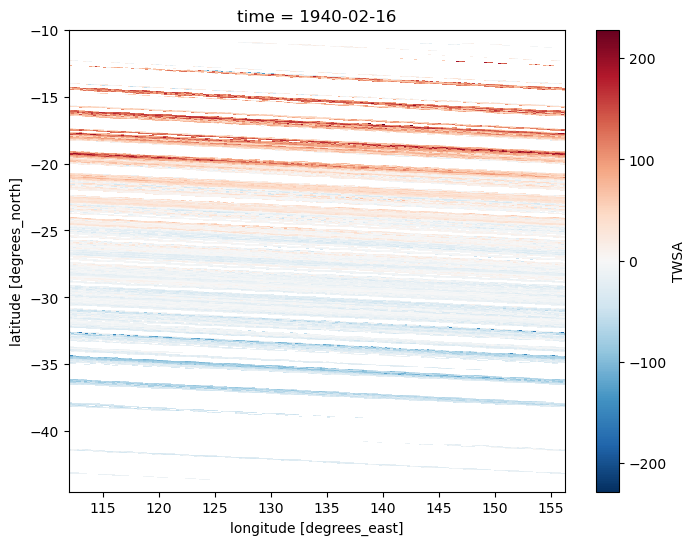

In [40]:
file = '/g/data/w97/mg5624/RF_project/Water_Storage/GTWS-MLrec/CSR-based_GTWS-MLrec_CWS_australia_0.05_grid.nc'
CWS = xr.open_dataarray(file)
CWS.isel(time=0).plot(size=6)
# CWS.data = np.ma.masked_invalid(CWS.data)
# print(CWS, CWS.data)
training_df = add_predictor_to_training_df(training_df, CWS, "CWS")
# training_df['CWS'].values = np.ma.masked_invalid(training_df['CWS'])
print(training_df['CWS'])

# training_df.dropna(axis=0, inplace=True)
# nans = training_df['CWS'].isna()
# print(training_df['CWS'][0], type(training_df['CWS'][0]))
# # print(point)
# print(training_df)

In [17]:
# print(training_df)

## Months

In [18]:
def add_cyclical_month_columns_to_training_df(training_dataframe):
    """
    Adds two extra columns to training dataframe (sine_month and cosine_month) to proved cyclical months.
    
    Args:
        training_dataframe (pd.DataFrame): Dataframe containing the training data
    """
    months  = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    month_numbers = np.arange(1, 13)

    angles = 2 * np.pi * month_numbers / 12
    sin_month = np.sin(angles)
    cos_month = np.cos(angles)

    month_data = {'Month': months, 'Sin_month': sin_month, 'Cos_month': cos_month}
    month_df = pd.DataFrame(month_data)
    
    merged_df = pd.merge(training_dataframe, month_df, on='Month', how='inner')

    return merged_df
    

training_df = add_cyclical_month_columns_to_training_df(training_df)

## NDVI

In [19]:
filepath = '/g/data/w97/mg5624/RF_project/NDVI/australia/'
filename = 'ndvi3g_geo_v1_1_1982-2022.nc'
NDVI = xr.open_dataarray(filepath + filename)

NDVI = xr.where((NDVI >= -0.3) | (NDVI <= 1), NDVI, np.nan)

# print(NDVI)
# NDVI_no_nan = NDVI.dropna(dim='time').dropna(dim='lat').dropna(dim='lon')
# lower_invalid = NDVI < -0.3
# upper_invalid= NDVI > 1

# invalid_values = NDVI_no_nan.where(lower_invalid | upper_invalid, drop=True)

# # print(invalid_values)

# print('max:', NDVI.max().item())
# print('min:', NDVI.min().item())
# # NDVI_lower_invalid = NDVI.where(~np.isnan(NDVI) < -0.3)
# print(np.nanmax(NDVI_lower_invalid.data), np.nanmin(NDVI_lower_invalid.data))
# NDVI_lower_invalid = ~np.isnan(NDVI_lower_invalid)
# print('NDVI points below -0.3:', NDVI_lower_invalid.data[NDVI_lower_invalid.data==True])

# NDVI_upper_invalid = NDVI.where(NDVI > 1, drop=True)
# NDVI_upper_invalid = ~np.isnan(NDVI_upper_invalid)
# print('NDVI points above 1:', NDVI_upper_invalid.data[NDVI_upper_invalid.data==True])

## Save Training Dataframe

In [20]:
training_df.to_csv(my_data_dir + f'RF_project/training_data/training_data.csv')
print(training_df.columns)

Index(['Year', 'Month', 'Year_Month', 'Location', 'Latitude', 'Longitude',
       'Drought', 'Precipitation', 'Acc_3-Month_Precipitation',
       'Acc_6-Month_Precipitation', 'Acc_12-Month_Precipitation',
       'Acc_24-Month_Precipitation', 'Acc_36-Month_Precipitation',
       'Acc_48-Month_Precipitation', 'Runoff', 'ENSO_index', 'IOD_index',
       'SAM_index', 'ET', 'PET', 'SMsurf', 'SMroot', 'Sin_month', 'Cos_month'],
      dtype='object')
